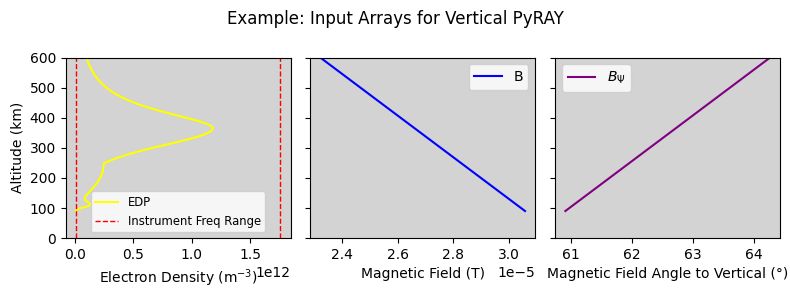

In [24]:
#!/usr/bin/env python
# --------------------------------------------------------
# Distribution Statement A. Approved for public release.
# Distribution is unlimited.
# This work was supported by the Office of Naval Research.
# --------------------------------------------------------
"""Example of generating input arrays for vertical PyRAY ray tracing.
"""

import datetime
import pickle

import numpy as np
import matplotlib.pyplot as plt

import PyIRI
import PyIRI.main_library as pyiri_main
import PyIRI.igrf_library as igrf
import PyRAY

# Select the day and Universal Time of interest
year = 2020
month = 4
day = 1
UT = 10.0

# F10.7 index for the selected day
F107 = 69.4

# Create datetime object for the selected day
dtime_day = datetime.datetime(year, month, day)

# Define geographic location (longitude, latitude in degrees)
lon = 10.0
lat = 0.0

# Create an array of altitudes (km)
aalt = np.arange(90., 600., 1.)

# Run PyIRI for the selected time and location
_, _, _, _, _, _, edp = pyiri_main.IRI_density_1day(year,
                                                    month,
                                                    day,
                                                    np.array([UT]),
                                                    np.array([lon]),
                                                    np.array([lat]),
                                                    aalt,
                                                    F107,
                                                    PyIRI.coeff_dir,
                                                    ccir_or_ursi=1)

# Extract 1-D electron density profile
den = edp[0, :, 0]

# Compute magnetic inclination and field strength at min and max altitudes
_, _, _, _, _, inc_min, bmag_min = igrf.inclination(PyIRI.coeff_dir,
                                                    dtime_day,
                                                    np.array([lon]),
                                                    np.array([lat]),
                                                    np.min(aalt))

_, _, _, _, _, inc_max, bmag_max = igrf.inclination(PyIRI.coeff_dir,
                                                    dtime_day,
                                                    np.array([lon]),
                                                    np.array([lat]),
                                                    np.max(aalt))

# Compute angles between the magnetic field and vertical ray
bpsi_min = PyRAY.library.vertical_to_magnetic_angle(inc_min[0])
bpsi_max = PyRAY.library.vertical_to_magnetic_angle(inc_max[0])

# Construct array of angles (°) between magnetic field and vertical ray
abpsi = np.linspace(bpsi_min, bpsi_max, aalt.size)

# Construct array of magnetic field strengths in Tesla (IGRF outputs nT)
abmag = np.linspace(bmag_min[0], bmag_max[0], aalt.size) / 1e9

# Generate array of frequencies used by a vertical ionosonde in MHz.
ionosonde_frequency = np.arange(1, 12, 0.1)

# Combine inputs into a dictionary
input_example = {'den': den,
                 'alt': aalt,
                 'bmag': abmag,
                 'bpsi': abpsi,
                 'freq': ionosonde_frequency}

# Save inputs to a pickle file
file_save = 'Example_input.p'
pickle.dump(input_example, open(file_save, "wb"))

# Plot the input arrays
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(8, 3)
fig.suptitle('Example: Input Arrays for Vertical PyRAY')

# Plot electron density profile
ax_plot = ax[0]
ax_plot.set_ylim([0, 600])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Electron Density (m$^{-3}$)')
ax_plot.plot(input_example['den'], input_example['alt'], c='yellow',
             label='EDP')
min_d = PyRAY.library.freq2den(np.min(ionosonde_frequency) * 1e6)
max_d = PyRAY.library.freq2den(np.max(ionosonde_frequency) * 1e6)
ax_plot.axvline(x=min_d, color='r', linestyle='--', linewidth=1, label='Instrument Freq Range')
ax_plot.axvline(x=max_d, color='r', linestyle='--', linewidth=1)
ax_plot.legend(fontsize='small')

# Plot magnetic field magnitude
ax_plot = ax[1]
ax_plot.set_ylim([0, 600])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field (T)')
ax_plot.plot(input_example['bmag'], input_example['alt'], c='blue',
             label='B')
ax_plot.legend()

# Plot angle between magnetic field and vertical
ax_plot = ax[2]
ax_plot.set_ylim([0, 600])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field Angle to Vertical (°)')
ax_plot.plot(input_example['bpsi'], input_example['alt'], c='purple',
             label='$B_{\\Psi}$')
ax_plot.legend()

plt.tight_layout()
